# Objective 1 Analysis: Characterizing T-Lineage Restriction of Lymphoid Progenitors through Phenotypic and Transcriptomic Analysis

In this notebook, we will be completing our analysis of Days 7 - Day 13 of the CD34+ Cells in LEM. 

The Research Questions of this Aim are: 
1. How are our 3 populations of interest related in genespace, indepdent of timepoints.  

2. How are our 3 populations changing, dependent on timepoints. 

3. How do the genes associated with Lymphoid commitment change through timepoints, within these populations

4. NULL

5. NULL

## Pre-Processing Workflow

Here, we begin by loading in necessary libraries, cleaning our data up to remove outliers from the UMAP space, and visualizing the general UMAP results. 

Let's begin with loading in the necessary libraries. The comments indicate what each library allows us to do in this workflow. 

In [1]:
# Loading Libraries

library(BiocSingular) # We need this to use the BioConductor libraries that work on the Single Cell data. #nolint
library(SingleCellExperiment) # We need this to use the SingleCellExperiment data structure.  # nolint
library(ggplot2) # we need this to make ggplot visualizations #nolint
library(tidyr) # we need this to manipulate data #nolint
library(dplyr) # we need this to manipulate data #nolint
library(patchwork) # to display plots side by side. #nolint
library(ggforce) # Allows me to display circles on ggplots. #nolint
library(limma) # helps with differential expression analysis #nolint
library(IRdisplay) # lets me display JPEGs in the notebook #nolint

# library(scuttle)
# library(scran)
# library(scater)
# library(GO.db)
# library(org.Hs.eg.db)
# library(scDblFinder)
# library(DropletUtils)
# library(DropletTestFiles)
# library(uwot)
# library(rtracklayer)
# library(PCAtools)
# library(celldex)
# library(SingleR)
# library(batchelor)
# library(bluster)


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

Based on the process outlined in `d0_Analysis.ipynb`, I've created SingleCell Objects containing eexperimental data from the d7-d13 timepoints. 

In [2]:
load("data/phenotype_with_ID.RData")
load("data/merge2.RData")


We have now loaded pre-processed merge2 data, and the associated phenotypes. Next, I will create an index linking cells to their phenotype. This will allow me to connect them to their flow_cytometry populations. 

In [3]:
pheno.d7 <- rep("CD34+CD45RA-CLEC12A-", 3039)
names(pheno.d7) <- colnames(merge2)[1:3039]

pheno.merge2 <- c(pheno.d7, pheno.d10, pheno.d13)


The next step would be to complete PCA on our top genes. This has already be done, we simply need to access it using the `reducedDimNames` command. 

In [4]:
# PCA has already been done on the top genes
reducedDimNames(merge2)


[1] "PCA.cc"    "UMAP.cc"   "PCA.5k"    "PCA.nocc"  "UMAP.nocc" "TSNE.nocc"
[7] "TSNE.5k"   "PCA"       "TSNE"

Ok nice - next we add phenotype metadata

In [5]:
# Add phenotypes as a column in colData
colData(merge2)$Phenotype <- pheno.merge2


As we can see, there's too many phenotypes present here. Lets break the data into our 3 populations of interest, and ignore everything else as an `Other` category, to better understand our question. 

In [6]:
# Establishing Population Groups

# Define phenotype groups
phenotype_groups <- list(
  Raneg_Cneg = c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-"), # Ra-C-
  Rapos_Cneg = c("CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-"), # Ra+C-
  Cpos = c("CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+"), # C+ # nolint
  Other = c("CD10+", "CD14CD15+") # Pro -B #Pro-NM #FW Gating from a flow cytometer #nolint
)

# Assign group labels to phenotypes
group_labels <- sapply(pheno.merge2, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(g) phenotype %in% g)] # nolint
  if (length(group) > 0) group else "Other"
})

# Add group labels to colData of the SCE object
colData(merge2)$Group <- group_labels


Nice! We can now begin visualizing the UMAP using the  `ggplot` package. 

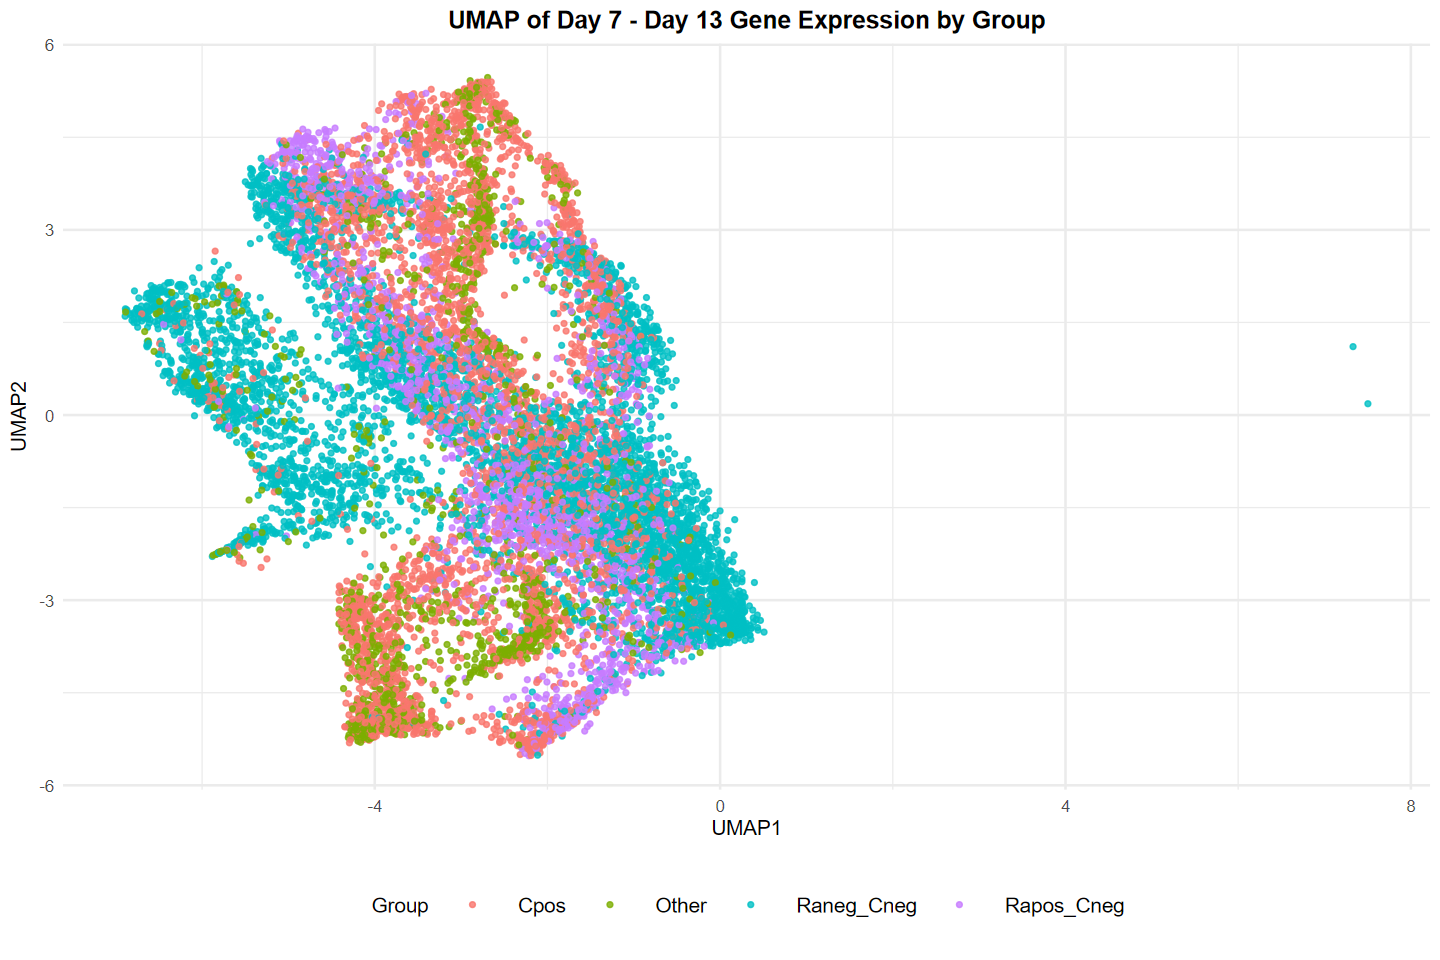

In [10]:
options(repr.plot.width = 12, repr.plot.height = 8)

umap_df <- reducedDim(merge2, "UMAP.cc") %>%
  as.data.frame() %>%
  mutate(Group = merge2$Group)


gg_umap <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Group)) +
  geom_point(alpha = 0.8, size = 1) +
  labs(
    title = "UMAP of Day 7 - Day 13 Gene Expression by Group",
    x = "UMAP1",
    y = "UMAP2",
    color = "Group"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.text = element_text(size = 12), # Increase legend text size
    legend.key.size = unit(1.5, "cm") # Increase legend color box size
  )

# Print the UMAP plot
print(gg_umap)


It appears that we have to outliers, with a value exceedin `UMAP1 = 4` on the x-axis. Lets get rid of these, and then continue with our analysis. 

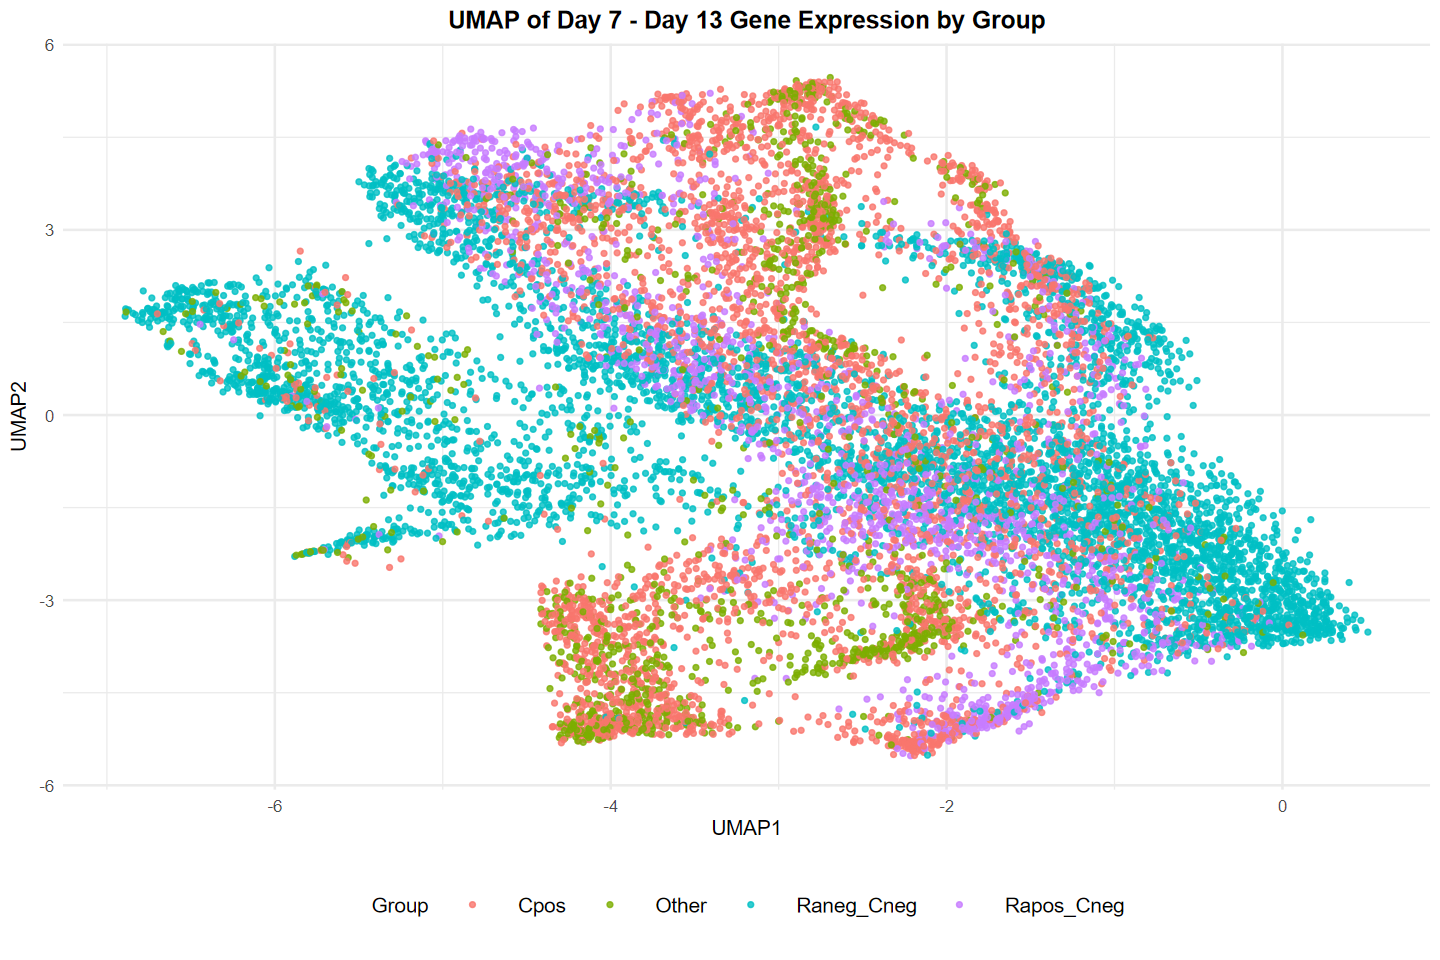

In [20]:
# Identify non-outlier cells
valid_cells <- which(reducedDim(merge2, "UMAP.cc")[, 1] < 4) # Filtering UMAP1 < 4

# Subset SingleCellExperiment object to keep only valid cells
merge2_clean <- merge2[, valid_cells]

# Confirming we get the sampe plot
umap_df <- reducedDim(merge2_clean, "UMAP.cc") %>%
  as.data.frame() %>%
  mutate(Group = merge2_clean$Group)


gg_umap <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Group)) +
  geom_point(alpha = 0.8, size = 1) +
  labs(
    title = "UMAP of Day 7 - Day 13 Gene Expression by Group",
    x = "UMAP1",
    y = "UMAP2",
    color = "Group"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.text = element_text(size = 12), # Increase legend text size
    legend.key.size = unit(1.5, "cm") # Increase legend color box size
  )
gg_umap


Next, lets add a column delineating which day each cell belongs to, so that we may analyze the differences in the three populations between each time point as well. 

In [14]:
# Extract the day information from cell names
colData(merge2_clean)$Day <- gsub(".*Day_([0-9]+).*", "\\1", rownames(colData(merge2_clean)))
# Convert to a factor (optional, for better categorical handling)
colData(merge2_clean)$Day <- factor(colData(merge2_clean)$Day, levels = sort(unique(colData(merge2_clean)$Day)))

colnames(colData(merge2_clean))


[1] "Sample"                            "Barcode"                          
 [3] "sum"                               "detected"                         
 [5] "subsets_Mito_sum"                  "subsets_Mito_detected"            
 [7] "subsets_Mito_percent"              "altexps_Antibody Capture_sum"     
 [9] "altexps_Antibody Capture_detected" "altexps_Antibody Capture_percent" 
[11] "total"                             "sizeFactor"                       
[13] "label"                             "scDblFinder.cluster"              
[15] "scDblFinder.class"                 "scDblFinder.score"                
[17] "scDblFinder.weighted"              "scDblFinder.difficulty"           
[19] "scDblFinder.cxds_score"            "scDblFinder.mostLikelyOrigin"     
[21] "scDblFinder.originAmbiguous"       "batch"                            
[23] "Phenotype"                         "Group"                            
[25] "Day"

## Analysis Workflow 

### RQ 1: How are the 3 Populations of Interest Related in the the Genespace? 

In this section, we will be looking at how the three populations are similiar, and how they are different, at a genespace level. The goal is to especially establish the changes in cell fate differences in the 3 populations. To then end, we will investigate the following objectives: 

1. Examining Spatial location of 3 populations of interest on UMAP.  

2. What is the genetic makeup of regions unique to a given population. Does this have functional implications? 

3. Are there indications of a Dendritic Cell Fate among the 3 populations. 

4. Are there indications of a Mast Cell Fate among the 3 populations, among one cell or another. 

5. What is the expression profile of Myeloid and Lymphoid genes between the C+ and Ra-C- populations. 

#### Obj 1: Visualizing the 3 Populations of Interest in the Genespace 

Lets begin by visualizing the 3 Populations in the genespace, and looking for qualitative differences and similarities. 

Nice! Lets begin by creating a faceted visualization, showing the distribution of the 3 populations overlaid in the same UMAP. 

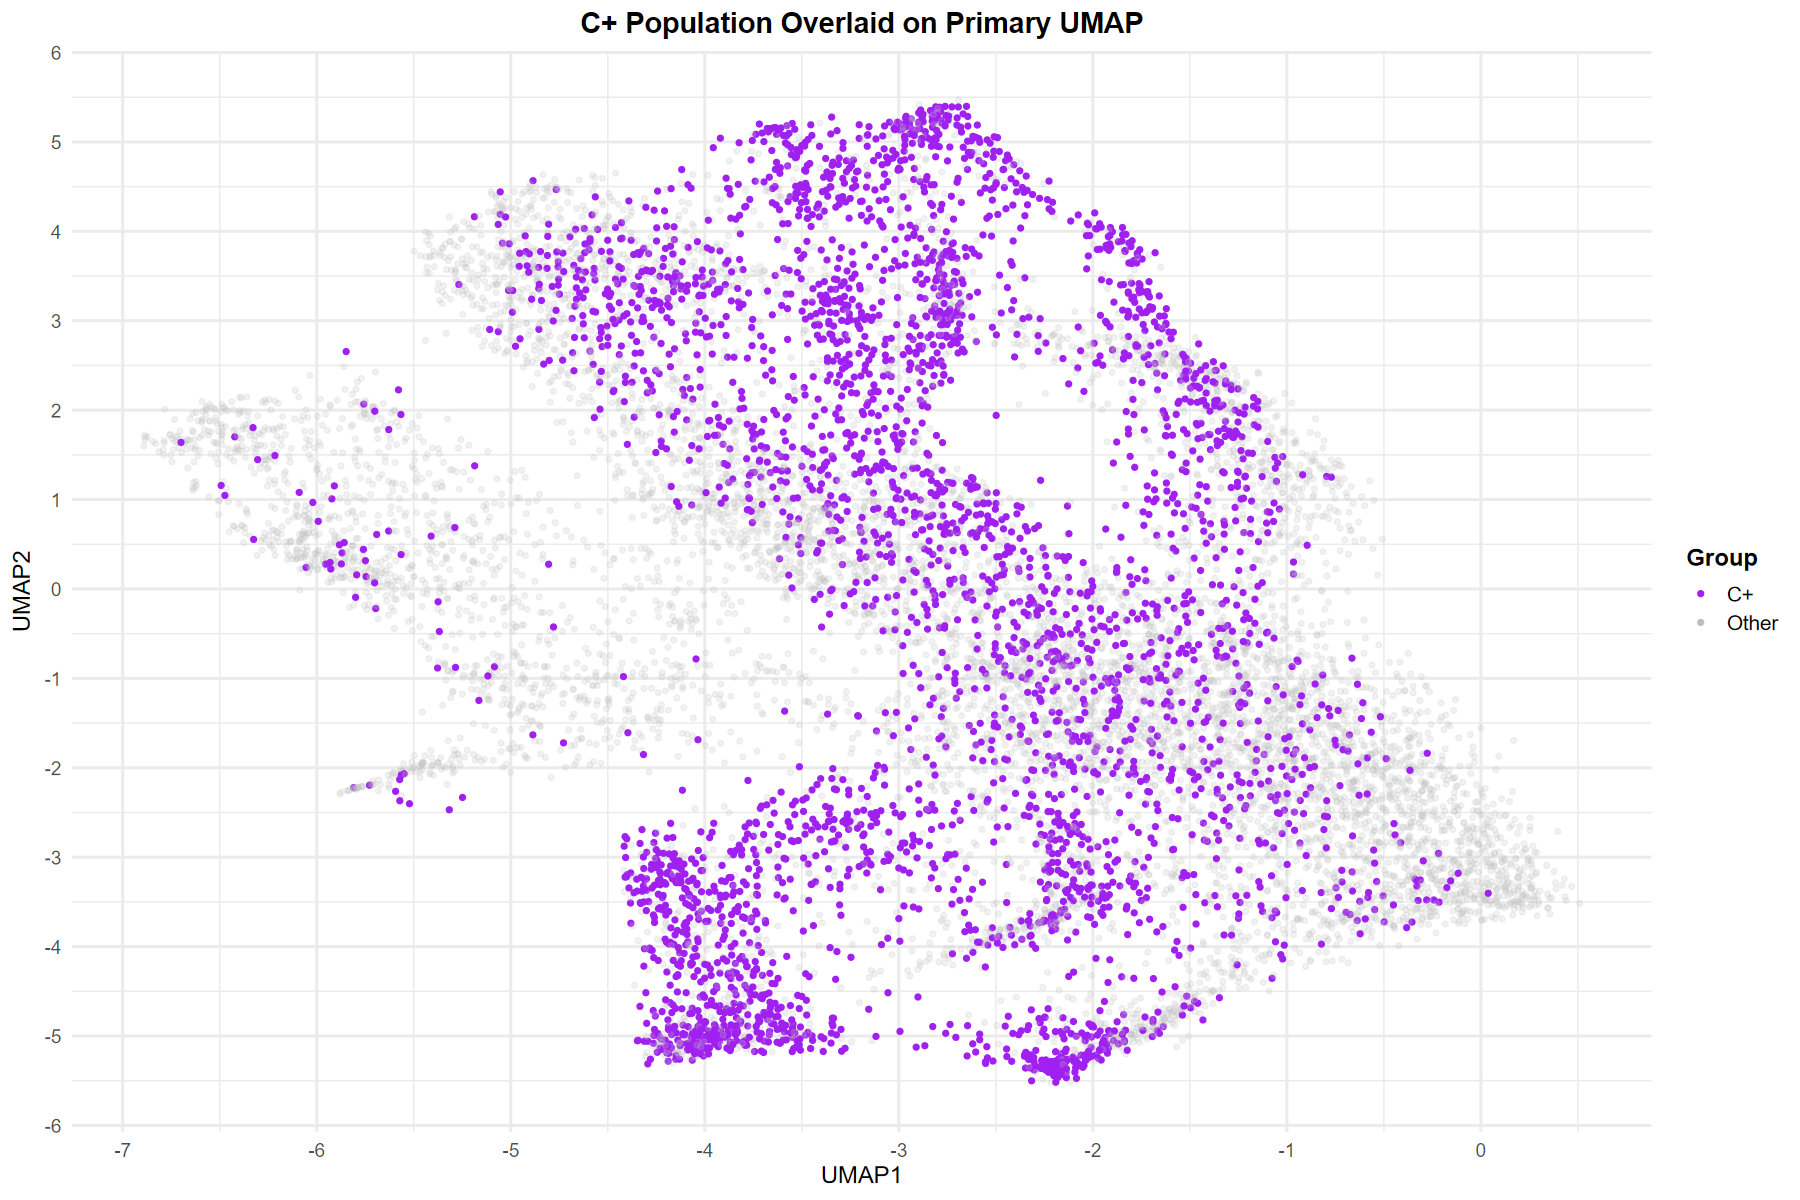

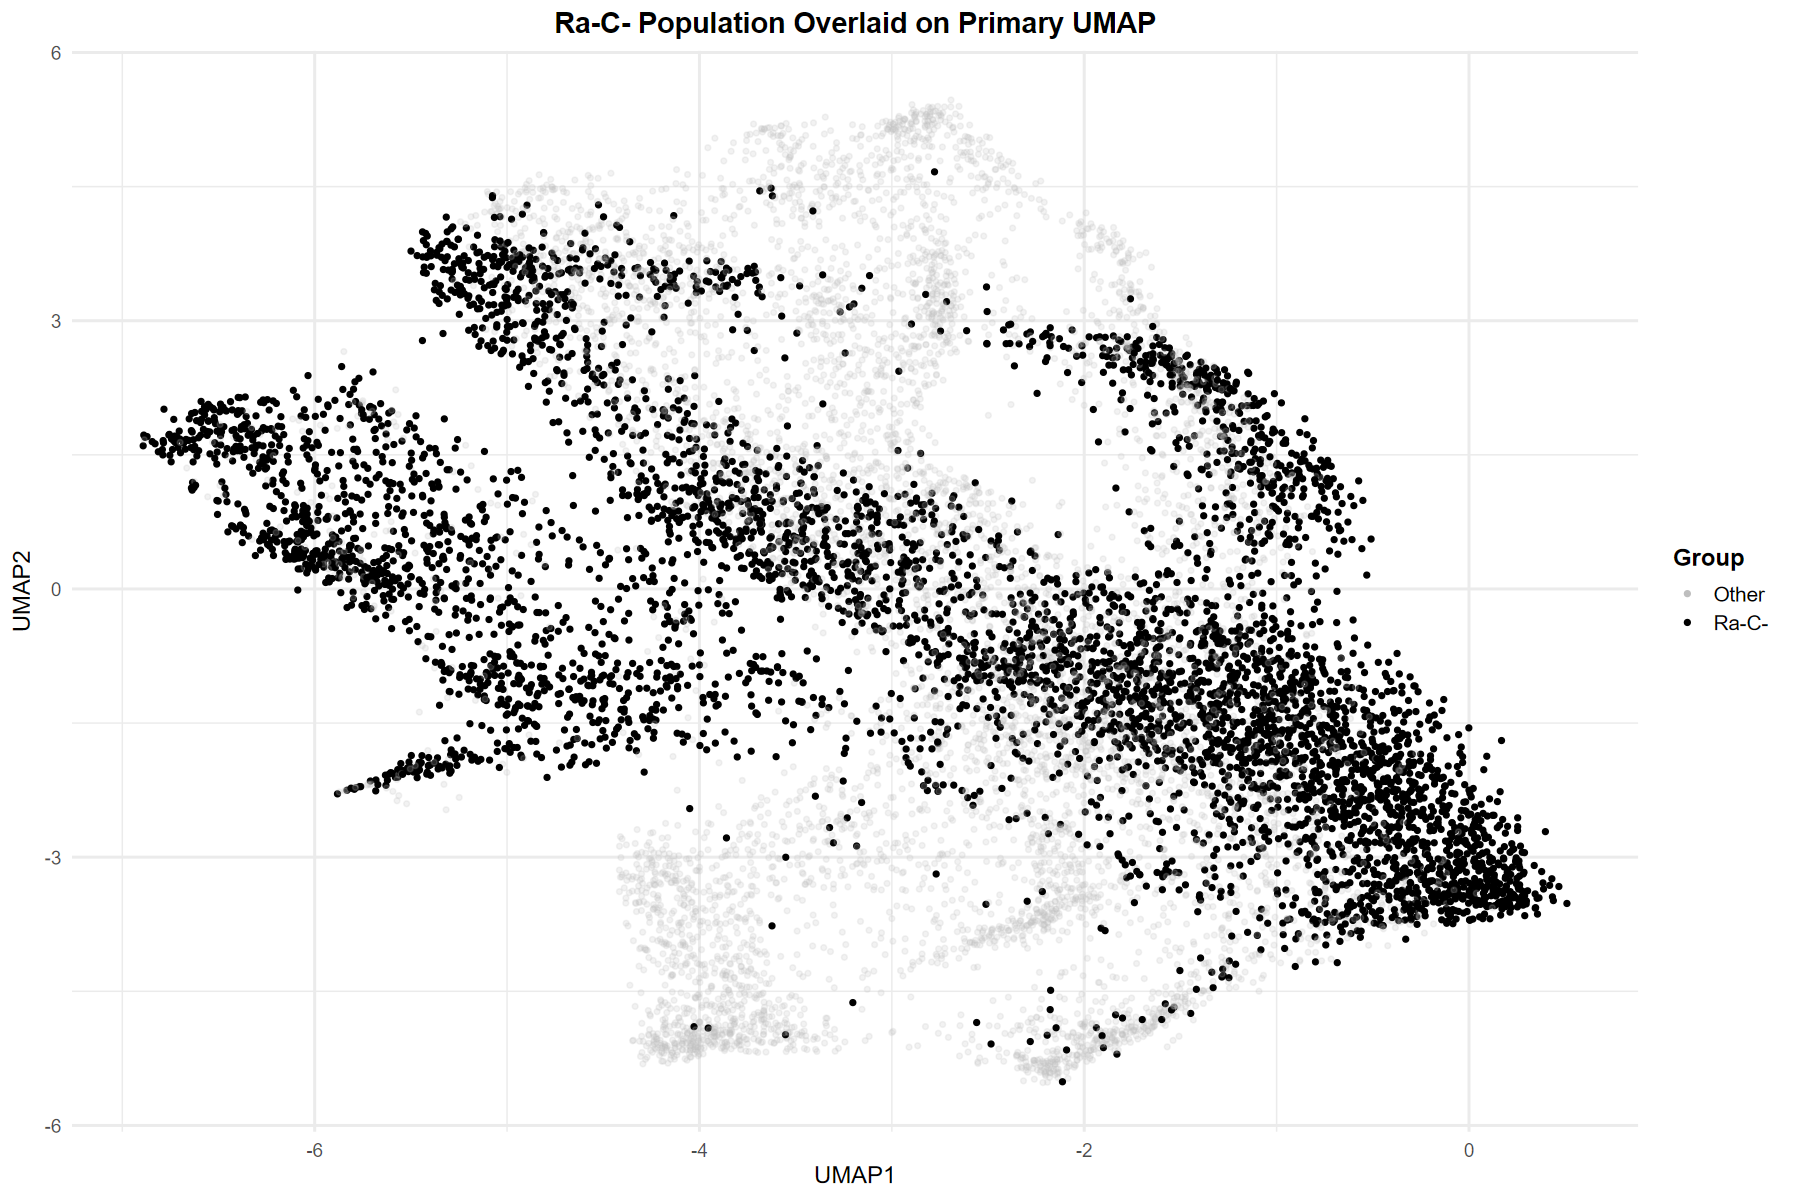

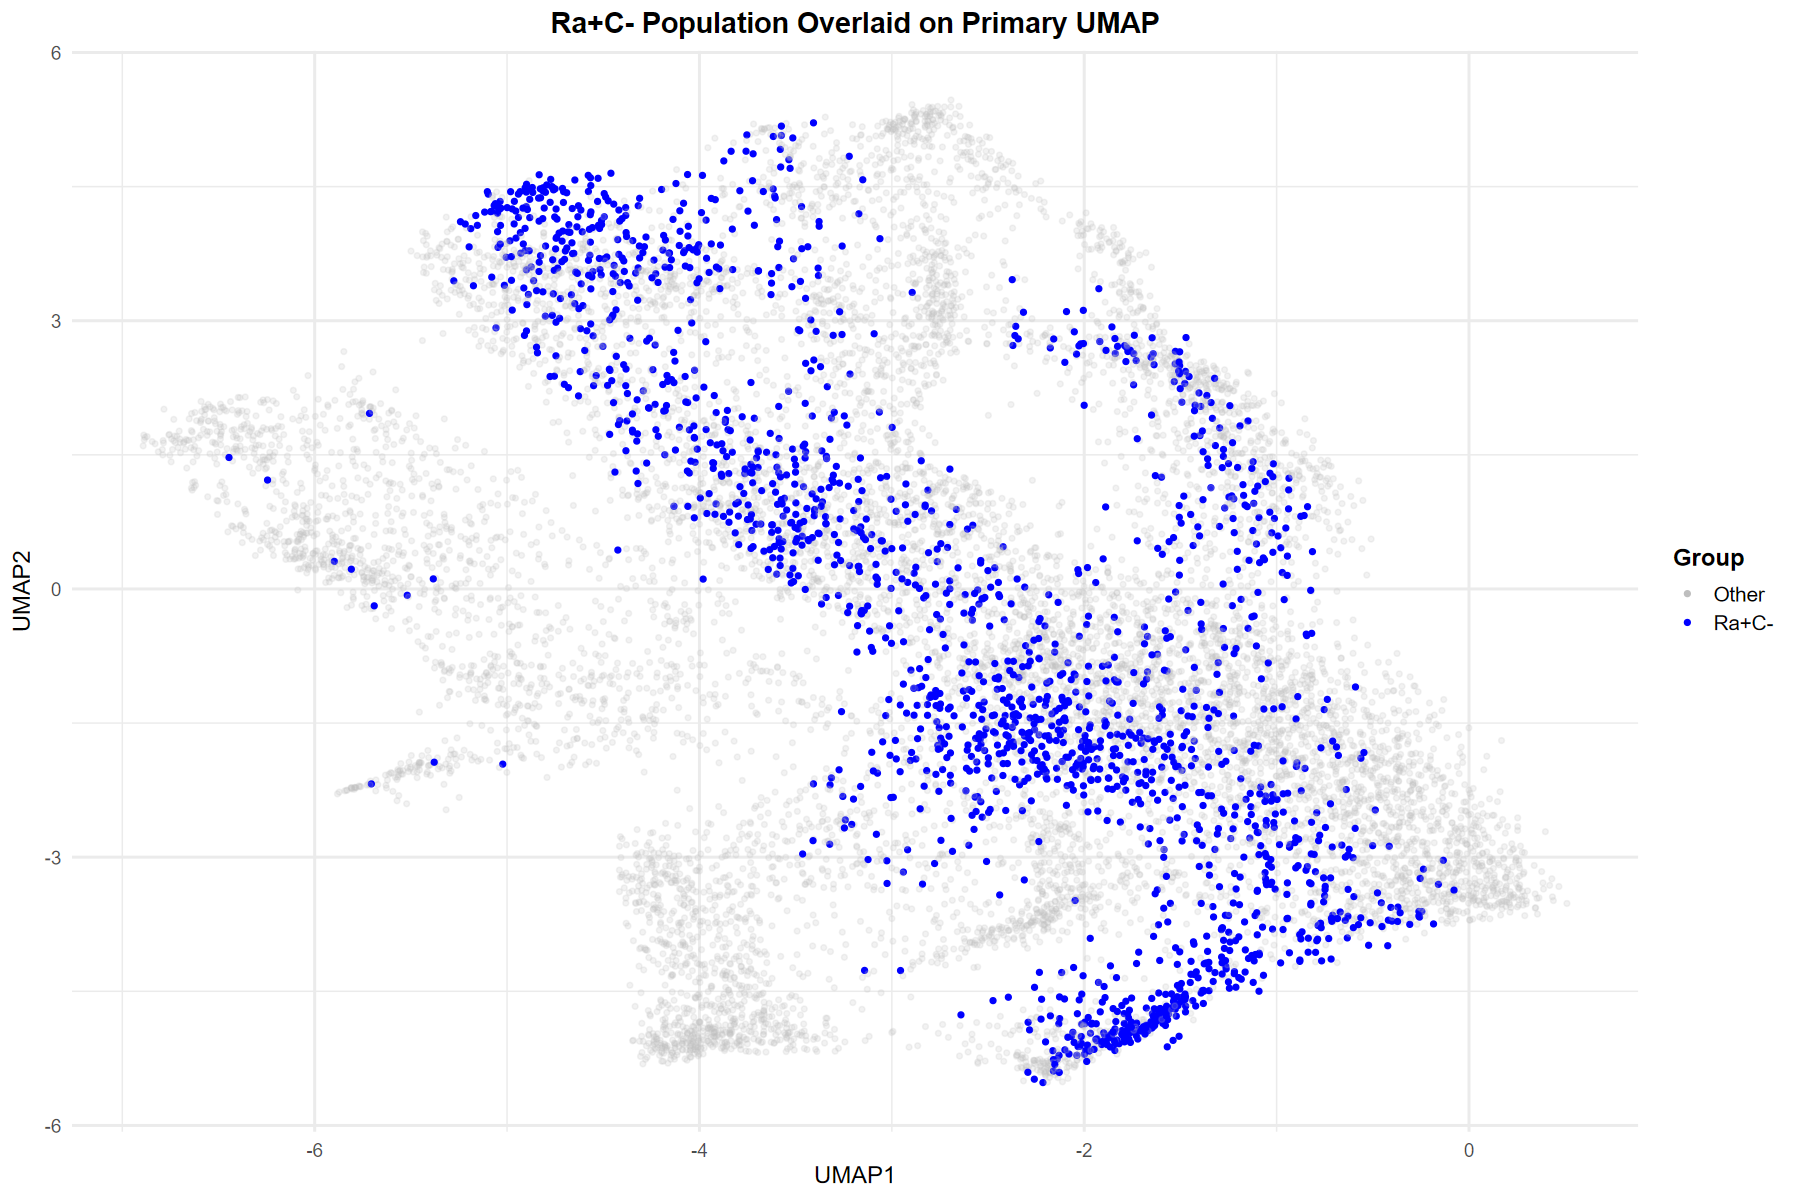

In [27]:
options(repr.plot.width = 15, repr.plot.height = 10)

gg_AllDay_AllPop <- gg_umap

gg_Cpos <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Cpos", "C+", "Other")),
    alpha = ifelse(umap_df$Group == "Cpos", 1, 0.2), size = 1
  ) +
  scale_color_manual(
    values = c("C+" = "purple", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "C+ Population Overlaid on Primary UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  ) +
  scale_x_continuous(breaks = seq(-7, 1, by = 1)) + # More x-axis ticks
  scale_y_continuous(breaks = seq(-7, 6, by = 1)) # More y-axis ticks


gg_RanegCneg <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Raneg_Cneg", "Ra-C-", "Other")),
    alpha = ifelse(umap_df$Group == "Raneg_Cneg", 1, 0.2), size = 1
  ) +
  scale_color_manual(
    values = c("Ra-C-" = "black", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "Ra-C- Population Overlaid on Primary UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  )

gg_RaposCneg <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Rapos_Cneg", "Ra+C-", "Other")),
    alpha = ifelse(umap_df$Group == "Rapos_Cneg", 1, 0.2), size = 1
  ) +
  scale_color_manual(
    values = c("Ra+C-" = "blue", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "Ra+C- Population Overlaid on Primary UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  )



# Print the UMAP plot
print(gg_Cpos)
print(gg_RanegCneg)
print(gg_RaposCneg)


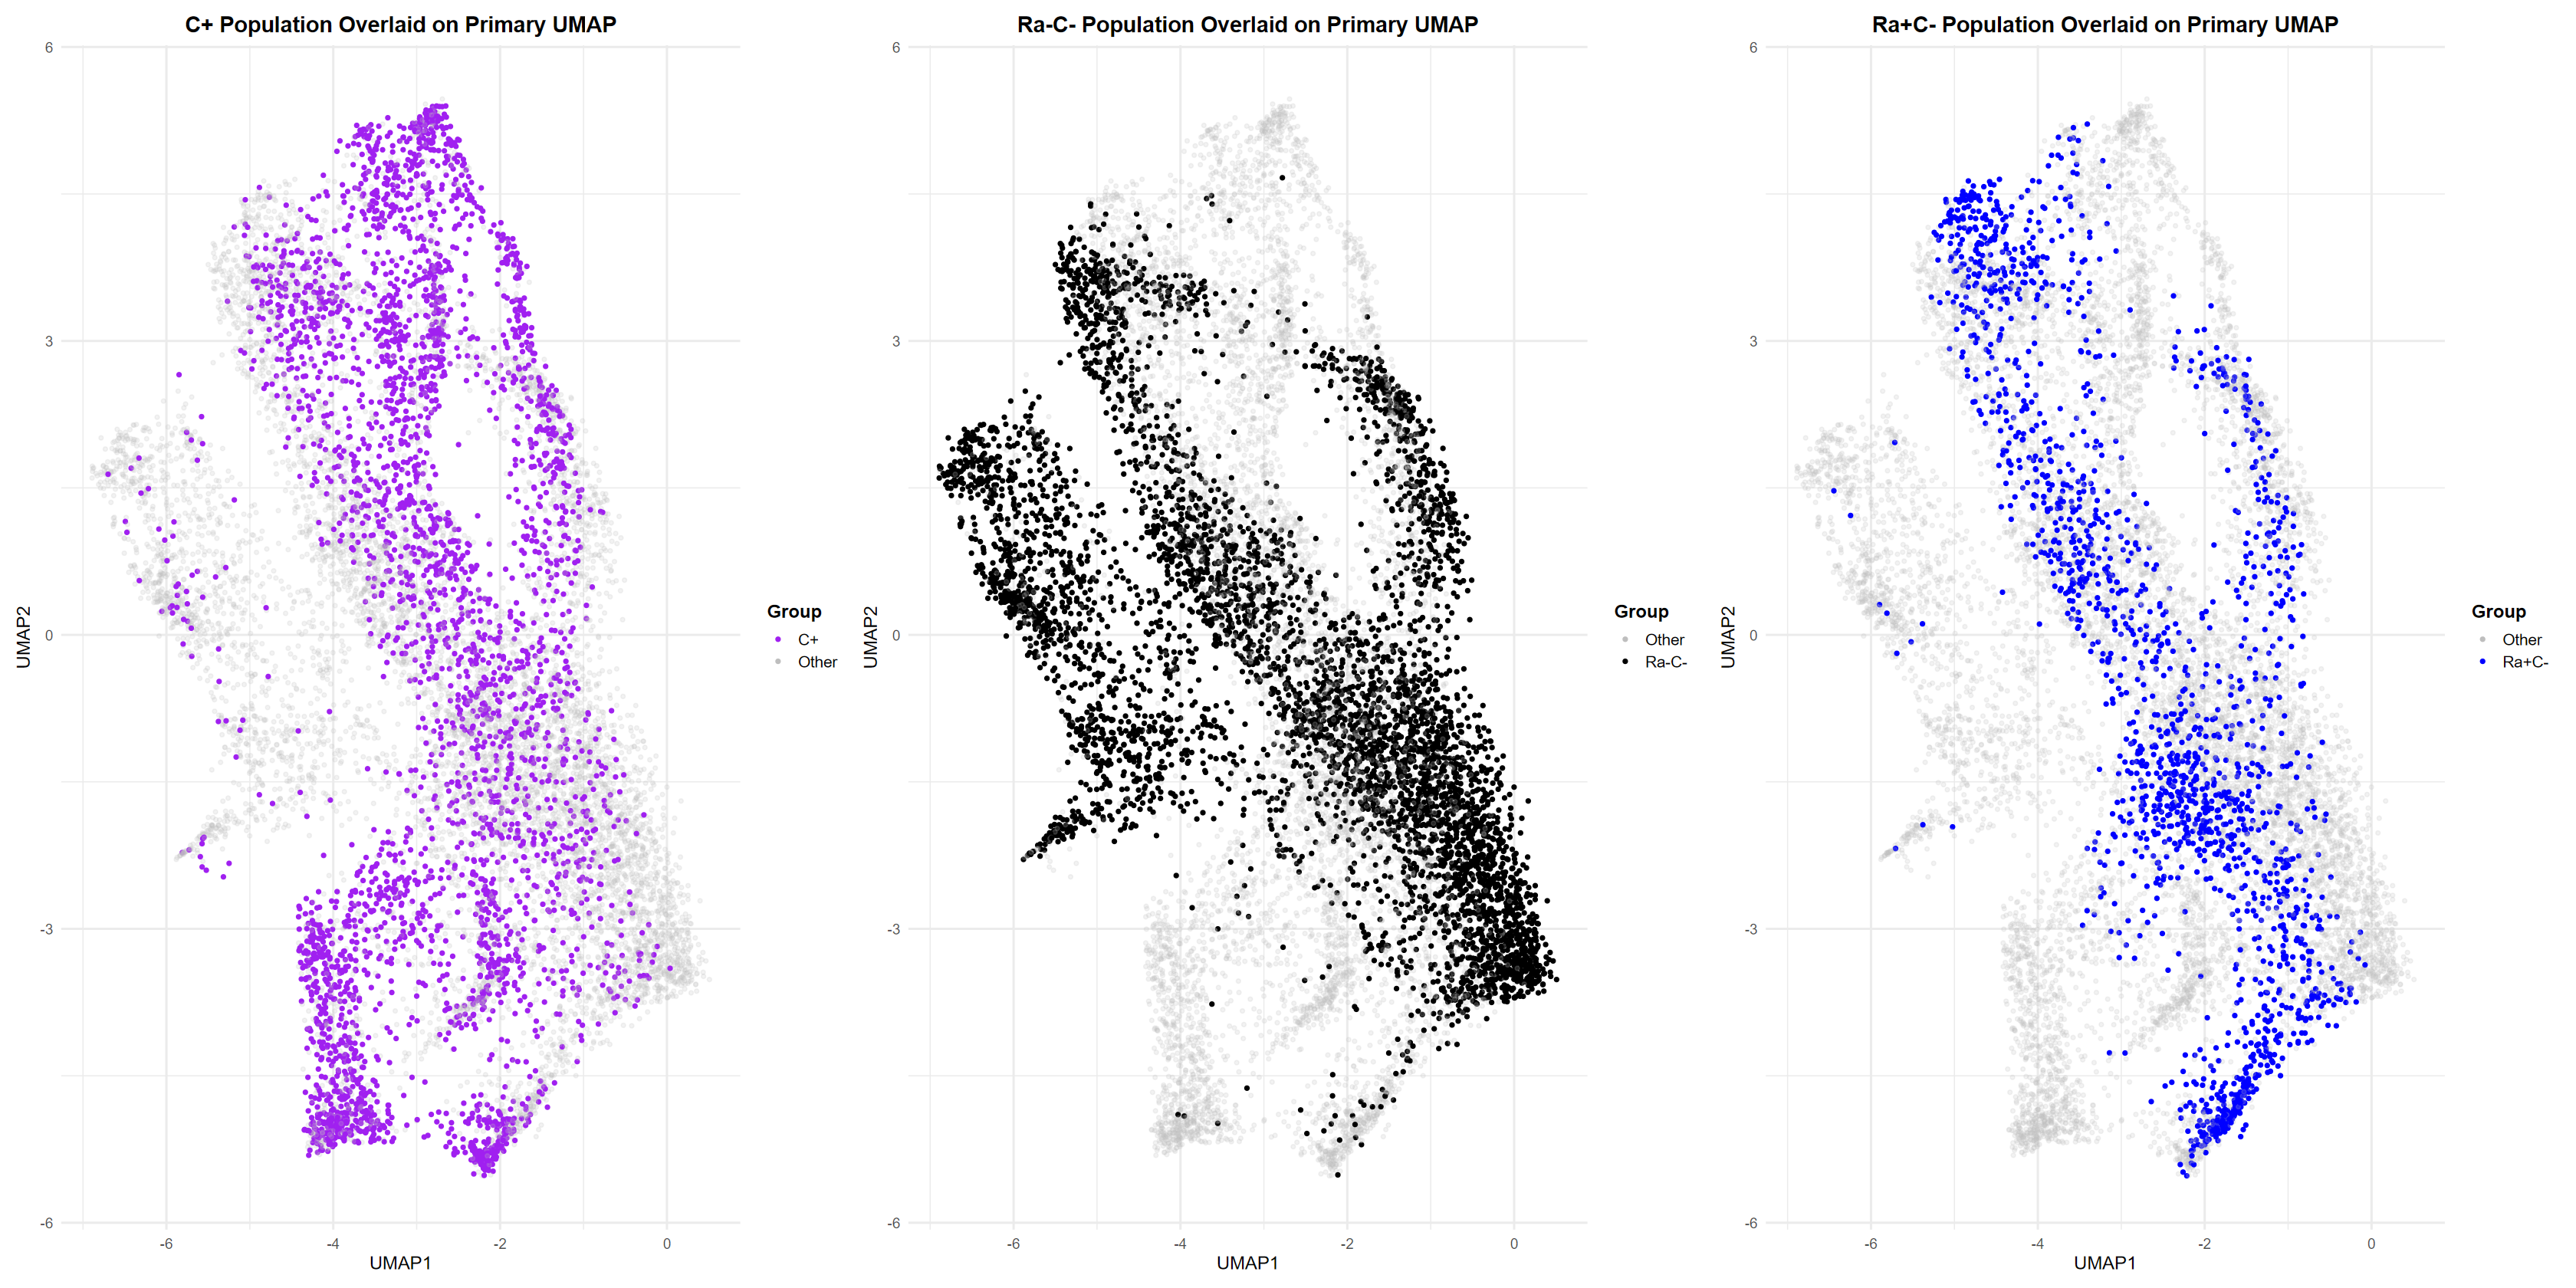

In [35]:
# Makes the plot nice and wide.
options(repr.plot.width = 28, repr.plot.height = 14)


# Combine two plots side by side
gg_combined <- gg_Cpos + gg_RanegCneg + gg_RaposCneg + plot_layout(ncol = 3)

# Print the combined plot
print(gg_combined)


Very interesting, what are some take-aways we can see from this distribution. Perhaps we can manually subset groups and complete DGE on them, to look for more pronounced differences between groups: 

1. All groups have some homogeneity along the diagonal, which is their primary region of overlap. 

2. At the bottom left, the island is primarily C+ cells. That area is dominated by the C+ cells, and nothing else. Hence, it appears to be a near homogenous C+ population that exists there, within this dataset. Similiarly, the peak at the top of the plot is also dominated by C+ cells, and could be another subset to look at when completing DGE. 

3. The larger island, on a diagonal from -4 to -7, seems to be primarily occuped by the Ra-C- population. Additionally, the bottom right peak also seems to be enriched for this population. 

4. The small long island at the bottom is very enriched for Ra+C- cells, but the lower half has some overlap with C+ population. Additionally, there is a small enrichment in the top left, which is unique to the population, but it is limited. 

Heres's the regions of interest highlighted with circles:  

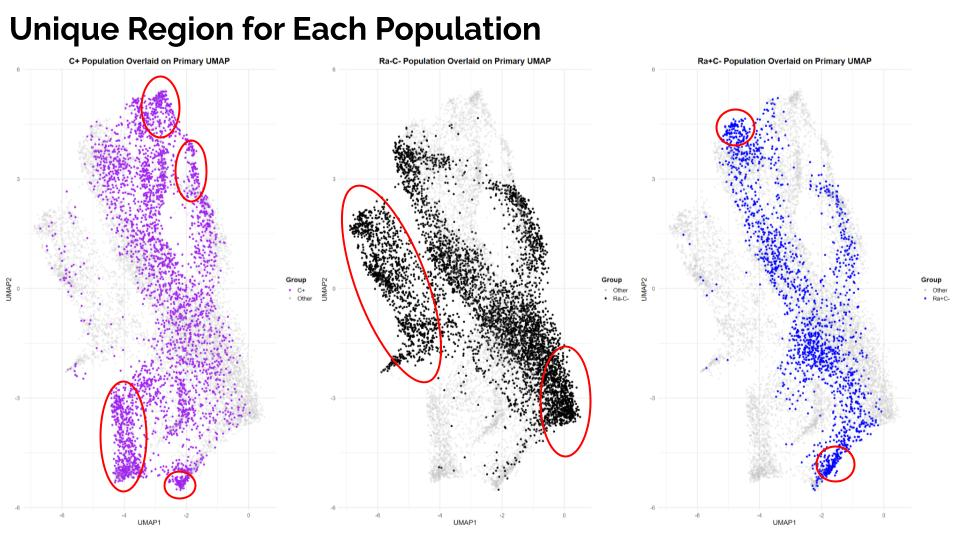

In [15]:
display_jpeg(file = "img/Aim1_TempResults.jpg")


#### Obj 2: What is the Genetic Makeup of Regions Unique to Each Population. Does it Have Functional Implications? 

Now that we have identified these unique regions, lets take a look at what genes are over-expressed in this locations, compared to the rest of the UMAP. This will give some hints into what is functionally  unique about these cells within each population - perhaps pointing to the existance of a subcluster/subpopulation with a linked fate.

To begin, we must modify our `Merg2` sce object to only contain cells that belong to these populations. Lets do that below: 

In [ ]:
# Identify unique cells for CPos
Cpos_unique <- which(reducedDim(merge2_clean, "UMAP.cc")[, 1] < 4) # Filtering UMAP1 < 4

# Subset SingleCellExperiment object to keep only valid cells
merge2_clean <- merge2[, valid_cells]


########

umap_coords <- as.data.frame(reducedDim(merge2_clean, "UMAP.cc"))
colnames(umap_coords) <- c("UMAP1", "UMAP2") # Ensure correct column names

# Defining Unique Regions
CPos <- subset(umap_coords, UMAP1 > -5 & UMAP1 < -3.5 & UMAP2 > 2 & UMAP2 < 4)


[1] "UMAP1" "UMAP2"

#### Comparing DGE Between the 3 Populations 

Okay - lets look at the differential gene expression among the 3 different populations. We will begin by completing `Differential Gene Expression` (DGE) analysis. Lets begin by making sure we have a `SingleCellObject` with the normalized expression data, and the necessary population grouping. 

In [12]:
# Load necessary libraries
library(limma) # For differential expression analysis
library(edgeR) # For statistical modeling of RNA-seq count data
# library(ComplexHeatmap) # For heatmap visualization


In [31]:
# Extract phenotype group labels
group_labels <- colData(merge2)$Group

# Subset to only cells belonging to the 3 populations of interest
selected_cells <- group_labels %in% c("Raneg_Cneg", "Rapos_Cneg", "Cpos")

expr_matrix <- assay(merge2, "logcounts")[, selected_cells]

# Ensure selected group labels match the subset
filtered_groups <- factor(colData(merge2)$Group[selected_cells])

# Generate the design matrix dynamically
design_matrix <- model.matrix(~ 0 + filtered_groups)


In [35]:
contrast_matrix <- makeContrasts(
    Rapos_vs_Raneg = filtered_groupsRapos_Cneg - filtered_groupsRaneg_Cneg,
    Cpos_vs_Raneg = filtered_groupsCpos - filtered_groupsRaneg_Cneg,
    Cpos_vs_Rapos = filtered_groupsCpos - filtered_groupsRapos_Cneg,
    levels = design_matrix
)

fit <- lmFit(expr_matrix, design_matrix)
fit <- contrasts.fit(fit, contrast_matrix)
fit <- eBayes(fit)

# Extract top 10 differentially expressed genes for Cpos vs Raneg_Cneg
top_genes <- topTable(fit, coef = "Cpos_vs_Raneg", number = 10, sort.by = "P")
print(top_genes)


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 3.0 GiB"
Warning message:
"Zero sample variances detected, have been offset away from zero"


          ID      logFC   AveExpr         t P.Value adj.P.Val         B
235   PIK3CD  0.6270711 0.7850651  40.02874       0         0  735.7793
596     CD52 -0.8143748 1.2169374 -40.22302       0         0  742.5716
2007 S100A11  0.8100011 1.2323557  40.11568       0         0  738.8157
2107    IL6R  0.5127783 0.3863052  43.77762       0         0  871.0415
2236    CD1D  0.3474733 0.1271355  40.49867       0         0  752.2505
2331  FCER1G  0.8941985 0.6370379  49.32831       0         0 1086.4791
2880    CD34 -0.7829890 0.9993518 -41.88724       0         0  801.7421
3269   CHRM3 -0.8301269 0.6708039 -47.71866       0         0 1022.2537
3887  SLC8A1  0.7385904 0.3575767  44.30621       0         0  890.8041
4112   MEIS1 -0.9729234 0.9422416 -52.25061       0         0 1206.4763


In [ ]:
# Extract logcounts for selected cells
expr_matrix <- assay(merge2, "logcounts")[, selected_cells]

# Ensure group labels only contain the selected cells
filtered_groups <- factor(group_labels[selected_cells])

# Create design matrix dynamically
design_matrix <- model.matrix(~ 0 + filtered_groups)

# Assign correct column names based on actual detected levels
colnames(design_matrix) <- levels(filtered_groups)

# Check structure to ensure correctness
print(dim(design_matrix))
print(colnames(design_matrix))


In [13]:
merge2


class: SingleCellExperiment 
dim: 36601 12181 
metadata(12): Samples scDblFinder.stats ... scDblFinder.stats
  scDblFinder.threshold
assays(2): counts logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(3): ID Symbol Type
colnames(12181): cell1Day_7 cell2Day_7 ... cell5137Day_13
  cell5138Day_13
colData names(24): Sample Barcode ... Phenotype Group
reducedDimNames(9): PCA.cc UMAP.cc ... PCA TSNE
mainExpName: Gene Expression
altExpNames(1): Antibody Capture

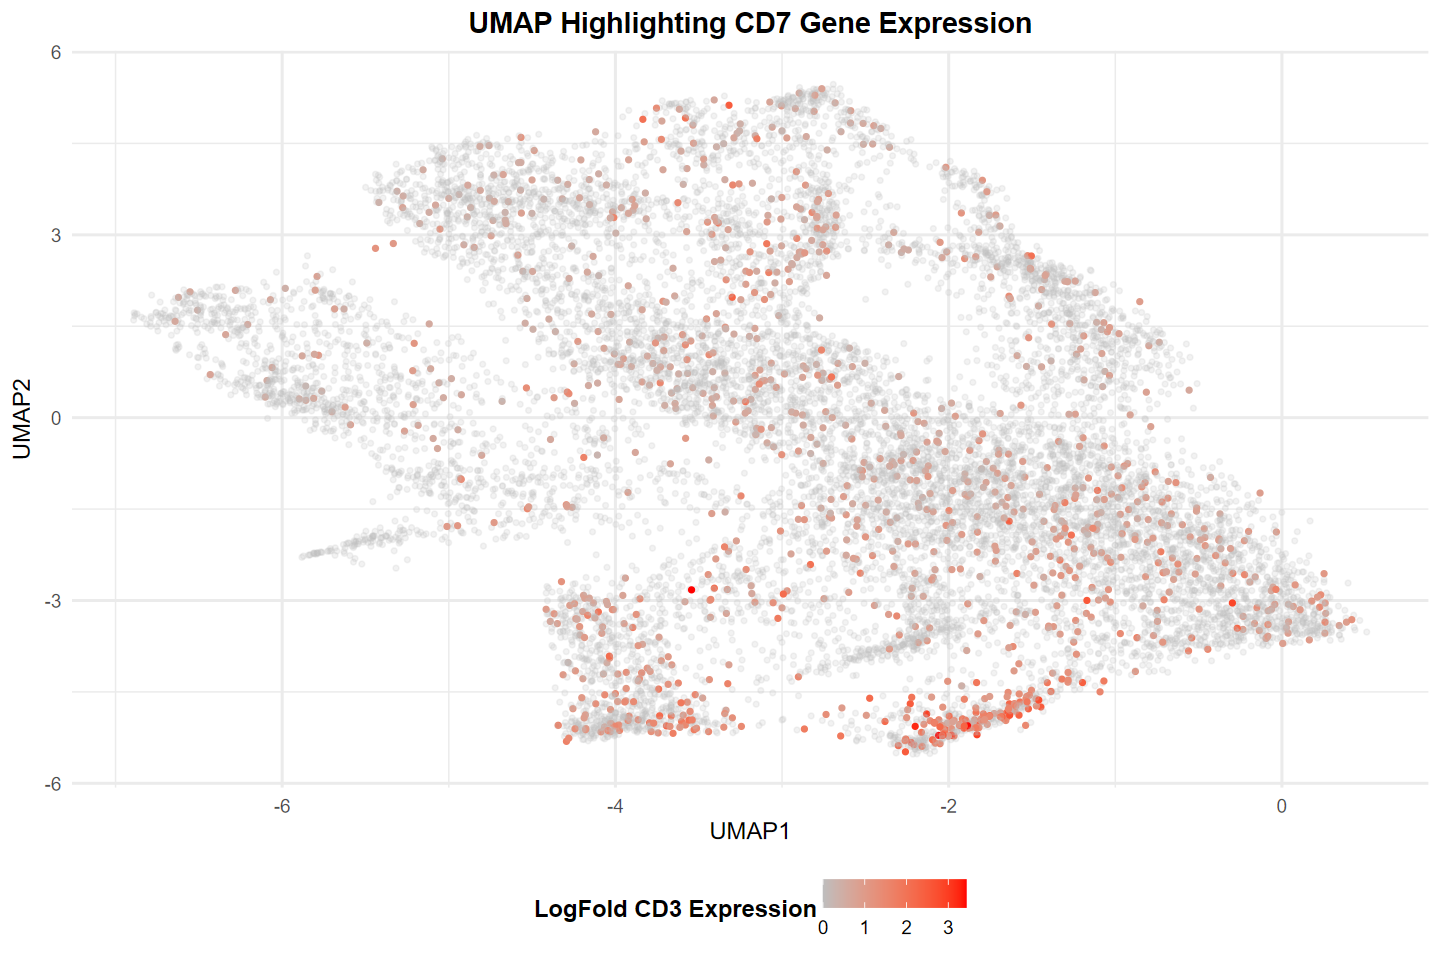

In [99]:
# Visualizing CD3 Expression across all populations and Timepoints

# Assuming "merge2" contains the logcounts assay and CD3 is the gene of interest
library(ggplot2)

# Extract CD3 gene expression values
cd3_expression <- assay(merge2, "logcounts")["CD7", ]

# Add CD3 expression to the UMAP dataframe
umap_df$CD3_expression <- cd3_expression

# Filter the UMAP dataframe to remove outliers
umap_df <- umap_df %>% filter(UMAP1 < 4)

# Create the plot
gg_umap_cd3 <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(
    aes(color = CD3_expression),
    alpha = ifelse(umap_df$CD3_expression > 0, 1, 0.2),
    size = 1
  ) +
  scale_color_gradient(
    low = "gray",
    high = "red",
    name = "LogFold CD3 Expression"
  ) +
  labs(
    title = "UMAP Highlighting CD7 Gene Expression",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.title = element_text(face = "bold")
  )

print(gg_umap_cd3)


In [138]:
# Establishing T cell Genes

T_genes <- c("TCF3", "RAG1", "GATA3", "TCF7", "NOTCH1", "BCL11B", "CD7")
B_genes <- c("TCF4", "PAX5", "TCF3", "RAG1", "RAG2", "BCL11A", "EBF1", "CD79A", "MEF2C")
gene_presence <- B_genes %in% rownames(merge2)
names(gene_presence) <- B_genes
gene_presence


TCF4   PAX5   TCF3   RAG1   RAG2 BCL11A   EBF1  CD79A  MEF2C 
  TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE

In [136]:
"EBF1" %in% rownames(merge2)


[1] TRUE

In [62]:
unique(pheno.merge2)


[1] "CD34+CD45RA-CLEC12A-" "CD34-CD45RA-CLEC12A+" "CD34+CD45RA-CLEC12A+"
 [4] "CD34+CD45RA+CLEC12A-" "CD34-CD45RA+CLEC12A-" "CD34+CD45RA+CLEC12A+"
 [7] "CD34-CD45RA-CLEC12A-" "CD34-CD45RA+CLEC12A+" "CD14CD15+"           
[10] "CD10+"

In [122]:
# Check unique values in Phenotype_Group
# Check unique values in Phenotype_Group
unique(expression_df$Phenotype_Group)


[1] "Group1" "Group3" "Group2" "Other"  "Group4"

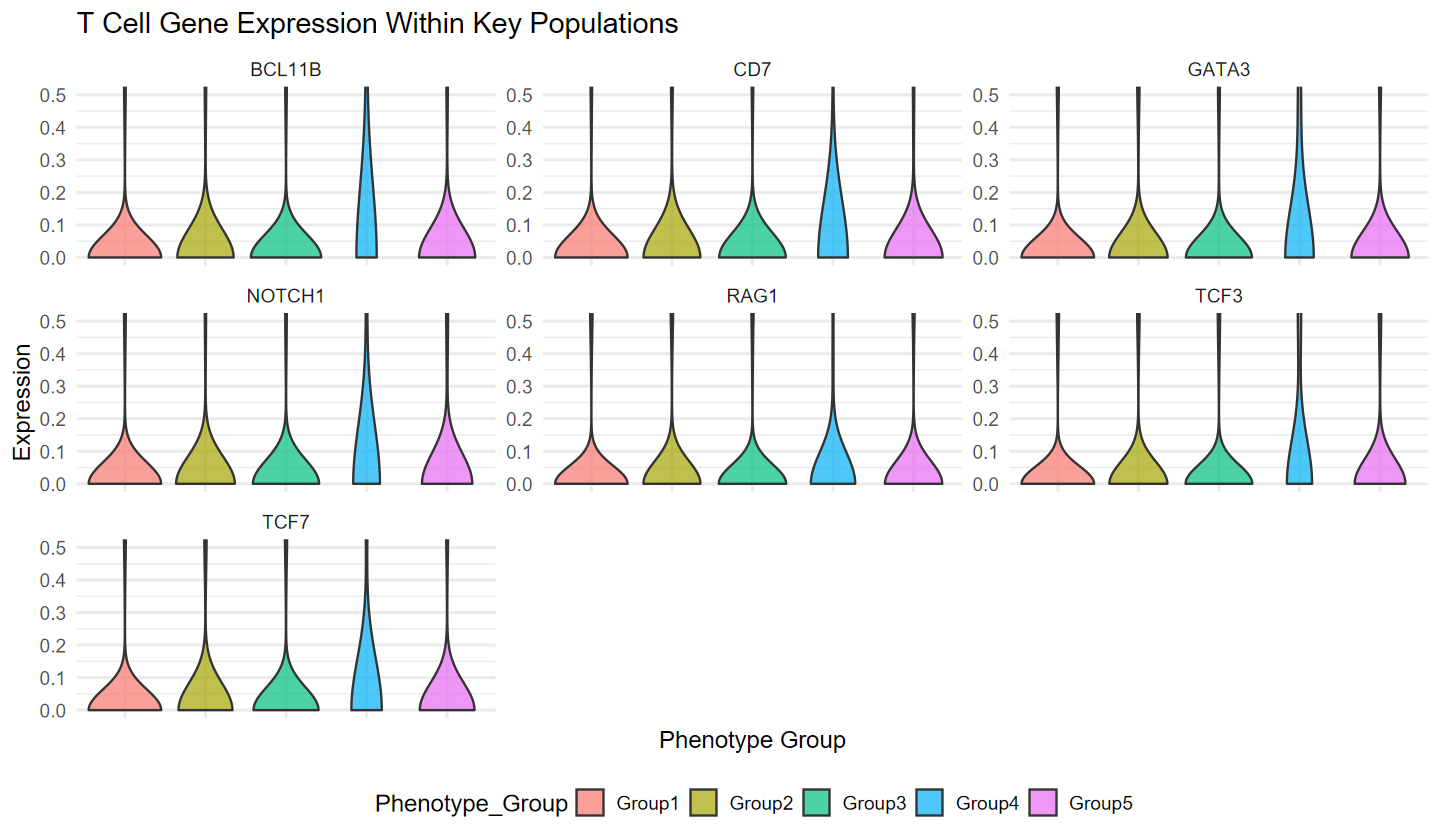

In [139]:
# T Cell Gene Expression Across Starting populations

library(ggplot2)

# Define the genes of interest
genes_of_interest <- T_genes # Replace with actual gene names

# Define the phenotypes to include in the comparison
phenotypes_of_interest <- c(
  "CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-",
  "CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+", "CD10+", "CD14CD15+"
) # Replace with actual phenotype names

# Extract expression data for the genes
gene_expression <- assay(merge2, "logcounts")[genes_of_interest, ]

# Combine data into a data frame
expression_df <- data.frame(
  Expression = as.vector(gene_expression),
  Gene = rep(genes_of_interest, each = ncol(gene_expression)),
  Phenotype = rep(pheno.merge2, times = length(genes_of_interest))
)

expression_df$Phenotype_Group <- sapply(expression_df$Phenotype, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(group) phenotype %in% group)]
  if (length(group) > 0) group else "Other"
})


# Example with extended plot width and group labels
library(ggplot2)

# Adjusting the plot size (for saving or interactive sessions)
options(repr.plot.width = 12) # Set a larger width for plotting

# Create the plot
ggplot(expression_df, aes(x = Phenotype_Group, y = Expression, fill = Phenotype_Group)) +
  geom_violin(trim = TRUE, alpha = 0.7) +
  facet_wrap(~Gene, scales = "free_y") +
  labs(
    title = "T Cell Gene Expression Within Key Populations",
    x = "Phenotype Group",
    y = "Expression"
  ) +
  coord_cartesian(ylim = c(0, 0.5)) + # Adjust the y-axis range to control tail length
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
  )


Great! Now lets do this again with B cell genes 

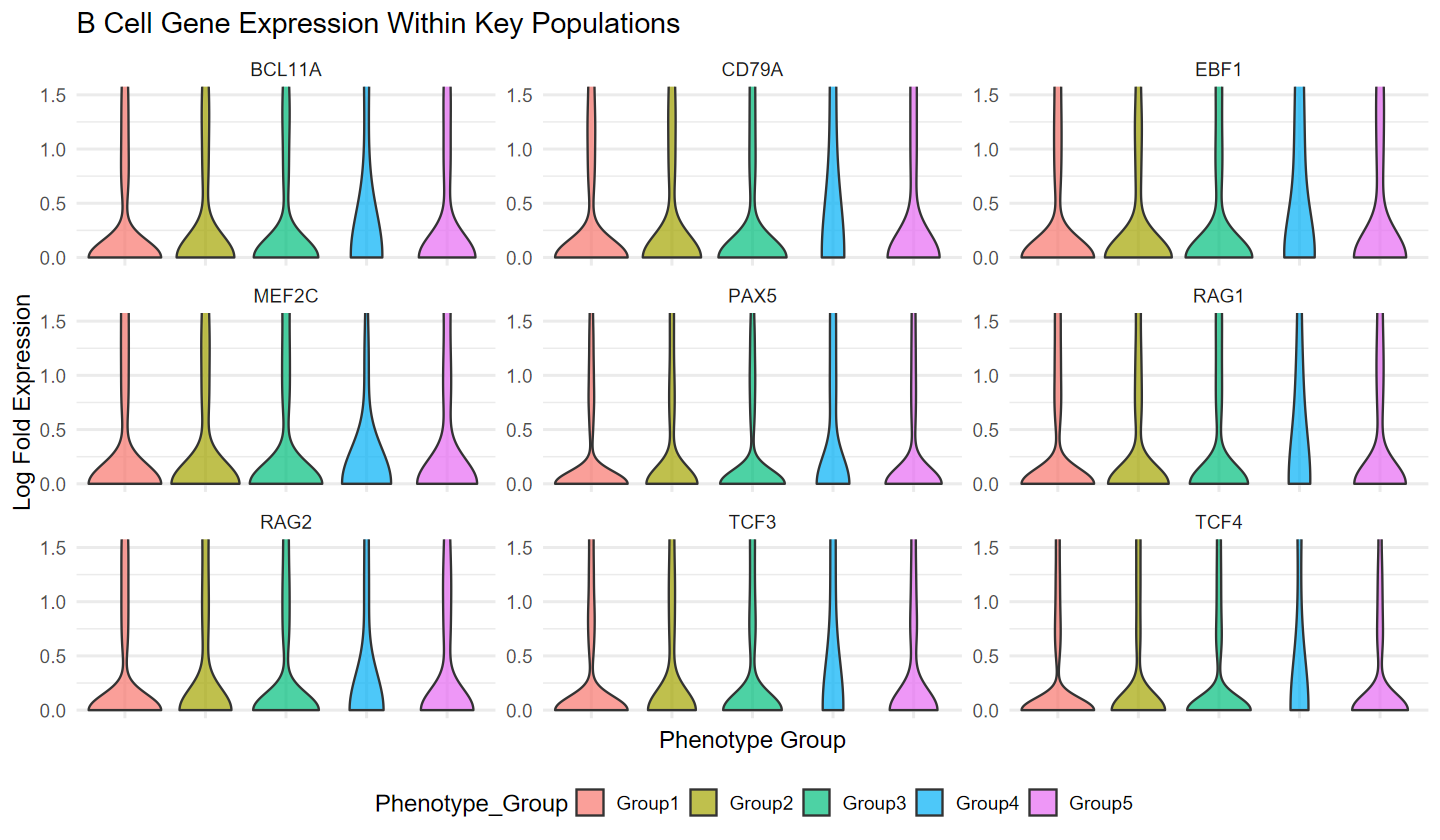

In [142]:
# B Cell Gene Expression Across Populations






library(ggplot2)

# Define the genes of interest
genes_of_interest <- B_genes # Replace with actual gene names

# Define the phenotypes to include in the comparison
phenotypes_of_interest <- c(
  "CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-",
  "CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+", "CD10+", "CD14CD15+"
) # Replace with actual phenotype names

# Extract expression data for the genes
gene_expression <- assay(merge2, "logcounts")[genes_of_interest, ]

# Combine data into a data frame
expression_df <- data.frame(
  Expression = as.vector(gene_expression),
  Gene = rep(genes_of_interest, each = ncol(gene_expression)),
  Phenotype = rep(pheno.merge2, times = length(genes_of_interest))
)

expression_df$Phenotype_Group <- sapply(expression_df$Phenotype, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(group) phenotype %in% group)]
  if (length(group) > 0) group else "Other"
})


# Example with extended plot width and group labels
library(ggplot2)

# Adjusting the plot size (for saving or interactive sessions)
options(repr.plot.width = 12) # Set a larger width for plotting

# Create the plot
ggplot(expression_df, aes(x = Phenotype_Group, y = Expression, fill = Phenotype_Group)) +
  geom_violin(trim = TRUE, alpha = 0.7) +
  facet_wrap(~Gene, scales = "free_y") +
  labs(
    title = "B Cell Gene Expression Within Key Populations",
    x = "Phenotype Group",
    y = "Log Fold Expression"
  ) +
  coord_cartesian(ylim = c(0, 1.5)) + # Adjust the y-axis range to control tail length
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
  )


In [130]:
# Check if CD7 exists in the rownames (genes) of the SCE object
"CD7" %in% rownames(merge2) # Replace merge2 with the name of your SCE object


[1] TRUE

In [ ]:
# head(pheno.merge2)

# merge2

# index.cd10 <- which(pheno.merge2 == "CD10+")
# merge2.cd10 <- merge2[, index.cd10]

# merge2.cd10


cell1Day_7             cell2Day_7             cell3Day_7 
"CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" 
            cell4Day_7             cell5Day_7             cell6Day_7 
"CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-"